In [1]:
import islpy as isl
from latex_op import display_latex
from islplot_support import plot_uset, plot_umap

# Polyhedral Representation

```c
const int N = 10;
double X[N], Y[N], Z[2*N];

for (int i = 0; i <= 2*N; ++i)
    S:  Z[i] = 0.0;
for (int i = 1; i <= N; ++i)
    for (int j = i; j <= N; ++j)
    T:  Z[i + j] += A[i] * B[j];
```

to

In [2]:
uset = isl.UnionSet("{T[i,j] : 0 < i <= j < 10; S[i,0] : 0 < i <= 20}")
display_latex(uset)

<IPython.core.display.Math object>

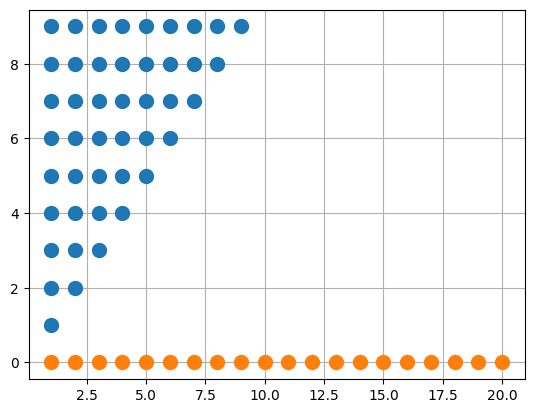

In [3]:
plot_uset(uset)

## Statement instances

Consider the following code fragment that computes a product of polynomials.
Each of the polynomials is represented by an array of its coefficients.

```c
const int N = 100;
double X[N], Y[N], Z[2*N];

for (int i = 0; i <= 2*N; ++i)
S:  Z[i] = 0.;
for (int i = 0; i <= N; ++i)
    for (int j = 0; j <= N; ++j)
T:      Z[i + j] += A[i] * B[j];
```

We will use labels to refer to statements.
Statement `S` initializes the elements of `Z` array and the `T` statement computes them.
Statement `S` is enclosed in a loop and is thus executed \\((2\mathtt{N} + 1)\\) times in the
following order.

* `Z[0] = 0.; /* i = 0 */`
* `Z[1] = 0.; /* i = 1 */`
* ...
* `Z[2*N] = 0. /* i = 2*N */;`

We refer to individual executions of a statement inside a loop as *statement instances*.
An instance can be identified by a statement label and the value of the iterator of the enclosing loop,
for example:
    
* $\mathtt{S}(0)$
* $\mathtt{S}(1)$
* ...
* $\mathtt{S}(2 \mathtt{N})$

If a statement is enclosed in multiple loops, its instances are identified by values of all iterators
in order of their nesting.
For example, statement `T` will have, among others, the instances

* $\mathtt{T}(0,0)$ for `Z[0] += A[0] * B[0] /* i = 0, j = 0 */`,
* $\mathtt{T}(0,1)$ for `Z[1] += A[0] * B[1] /* i = 0, j = 1 */`,
* ...
* $\mathtt{T}(\mathtt{N},\mathtt{N})$ for `Z[2*N] += A[N] * B[N] /* i = N, j = N */`.

## Iteration domain
The set of all instances of a statement is referred to as *(iteration) domain* of a statement.
Iteration domains can be expressed using the set-builder notation.
For example, 

$$
\mathcal{D}_\mathtt{S} = \{ \mathtt{S}[i] : 0 \leq i \leq \mathtt{N} \}
$$

The expression $0 \leq i \leq \mathtt{N}$ comes directly from the loop lower (`i=0`) and upper (`i<=N`) bounds.
The loop iterates for $i$ ranging from 0 to $\mathtt{N}$ inclusive.

The set we defined is *named*, i.e. the statement name $\mathtt{S}$ is mentioned before the
list of loop iterator names.
Note that $\mathtt{N}$ here is treated as a symbolic constant.
In the context of the polyhedal model, such symbolic constants are referred to as *(structure) parameters*.
Parameters are explicitly mentioned in the set description,
$$
\mathcal{D}_\mathtt{S} = [N] \rightarrow \{ \mathtt{S}[i] : 0 \leq i \leq N \}
$$
essentially turning it into a map from the parameter value to a concrete instance of a domain set.
Such parametric sets can be defined in *isl* as follows.

In [4]:
D_S = isl.Set("[N] -> {S[i]: 0 <= i <= N}")
display_latex(D_S)

<IPython.core.display.Math object>


Similarly, we can define the iteration domain of the statement `T`,
$$
\mathcal{D}_\mathcal{T} = [N] \rightarrow \{ \mathtt{T}(i,j) : 0 \leq i,j \leq N \}
$$

This domain is defined as a set of two-dimensional vectors.
Each component of a vector corresponds to an enclosing loop, in nesting order.

### Question
Define the variable `D_T` so that it contains the iteration domain of `T` using *isl* notation, then print it.

In [5]:
#!Solution
D_T = isl.Set("[N] -> {T[i,j]: 0 <= i,j <= N}")
display_latex(D_T)

<IPython.core.display.Math object>

As you may see, *isl* output uses conjunction (logical *and*) to combine inequalities around different iterators.
This can be handy if the loop bounds differ.  Use `and` in *isl* syntax to express conjunction.

### Question
Re-define `D_T` using `and` operator to separate bounds on `i` and `j`.

In [6]:
#!Solution
D_T = isl.Set("[N] -> {T[i,j]: 0 <= i <= N and 0 <= j <= N}")
display_latex(D_T)

<IPython.core.display.Math object>

If you already have an *isl* set, you can print it to see the expected syntax.

In [7]:
print(D_S)

[N] -> { S[i] : 0 <= i <= N }


### Question
Print `D_T` and see whether the output corresponds to your definition.

In [8]:
#!Solution
print(D_T)

[N] -> { T[i, j] : 0 <= i <= N and 0 <= j <= N }


Note that the output does not necessarily reproduce the textual form of the input.
Rather, it represents the same set after simplification.
In particular, redundant inequalities are eliminated and components that appear in first positions are expressed using simpler equations.
Here is an example of the simplification result.

In [9]:
print(isl.Set("{[i,j]: i+j >= 0 and i >= 0 and j > 0 and j >= 1}"))

{ [i, j] : i >= 0 and j > 0 and j >= -i }


## Handling Non-Unit Strides
Consider now the following code snippet that negates every odd element in the array.
```c
const int N;
double A[2*N];

for (int i = 1; i < 2*N; i += 2)
R:  A[i] = -A[i];
```
If `A` stores real and imaginary parts of complex numbers, one after other, this operation computes a complex conjugate.

The iteration domain of `R` should now be restricted to odd values of `i`.
This can be achieved using a modulo operator
$$
\mathcal{D}_\mathtt{R}: [N] \rightarrow \{ [i] : 0 \leq i < N \wedge i\mod 2 = 1 \} 
$$
which can be translated directly into *isl* syntax.

In [10]:
D_R = isl.Set("[N] -> {R[i]: i mod 2 = 1 and 0 <= i < 2 N}")
display_latex(D_R)

<IPython.core.display.Math object>

As you may see, *isl* transforms the modulo operation into division with floor rounding.
This transformation is a combination of two properties of the modulo operation

$ a \mod b = c \Leftrightarrow (a + c) \mod b = 0 $

$ a \mod b \equiv a - b \lfloor a/b \rfloor $

### Question
Define the set representing the iteration domain of `Q` in the following code, then print it
```c
const int N;
double A[2*N];

for (int i = 1; i < 2*N; i += 2)
Q:  A[i] = -A[i];
```

In [11]:
#!Solution
D_Q = isl.Set("[N] -> {Q[i]: i mod 2 = 0 and 0 <= i < N}")
display_latex(D_Q)

<IPython.core.display.Math object>

## Handling Conditions
Conditional constructs inside the loop also limit the iteration domain of the statements they enclose.
The complex conjugate computation can also be re-written using a branch inside the unit-stride loop.
```c
const int N;
double A[2*N];

for (int i = 1; i < 2*N; ++i)
    if (i % 2 == 1)
P:    A[i] = -A[i];
```
The definition of the iteration domain should also include the constraint imposed by the branches surrounding the statement.

### Question
Define the set representing the iteration domain of `P` and print it.

In [12]:
#!Solution
D_P = isl.Set("[N] -> {P[i]: i mod 2 = 1 and 0 <= i < N}")
display_latex(D_P)

<IPython.core.display.Math object>

Even though the set of statement instances are identical for `P` and `R`, these domains would be considered different *because of different statement names*.

### Question
What do you need to change in the definition of `D_P` to make it equal to `D_R`? 
Change it and check using `D_P.is_equal(D_R)`.

In [13]:
#!Solution
D_P = isl.Set("[N] -> {R[i]: i mod 2 = 1 and 0 <= i < 2N}")
print(D_P)
print(D_P.is_equal(D_R))

[N] -> { R[i] : (1 + i) mod 2 = 0 and 0 <= i < 2N }
True


## Iteration Domains as Presburger Sets
Because *isl* operates on Presburger Sets, it can encode any iteration domain that can be expressed using Presburger formulas.
This typically involves the statements surrounded by loops and branches with the so called *static control flow*.
That is, loop bounds and branch conditions are Presburger formulas of outer loop bounds and parameters.
The values of parameters are unknown but must be constant throughout the execution.
As a corollary, the control flow cannot depend on *values* being computed.
Hence the program parts amenable to the polyhedral modeling are referred to as *static control parts* or *SCoPs*.

### Question
Define the iteration domain of the only statement, enclosed in two loops and a branch with a disjunctive constraint.

Hint: use the operator `or` and parentheses to ensure the precedence if necessary.
```c
for (int i = 0; i < 10; ++i)
  for (int j = 0; j < 10; ++j)
    if (i < j - 1 || i > j + 1)
      Z[i][j] = 0.;
```

In [14]:
#!Solution
D = isl.Set("{[i,j]: 0 <= i,j < 10 and (i < j - 1 or i > j + 1)}")
display_latex(D)

<IPython.core.display.Math object>

It is also possible to express certain common mathematical operations using the Presburger formulas

* `i >= max(a,b)` $\Leftrightarrow i \geq a \wedge i \geq b$ (lower bound only)
* `i <= min(a,b)` $\Leftrightarrow i \leq a \wedge i \leq b$ (upper bound only)
* `a = ceil(b/c)` $\Leftrightarrow a = \lfloor (b - 1)/c \rfloor + 1$

## Putting Domains Together
In summary, an iteration domain of a statement is a set of multidimensional vectors constrained by the affine expressions that appear in loop bounds and branch conditions surrounding the statement.

Iteration domains of multiple statements live in different *spaces* due to different statement names, even if they are enclosed by the same loops.
They can be managed together by putting them into a union set.  For example, the combined domain of
```c
for (int i = 0; i < 10; ++i)
  for (int j = 0; j < 10; ++j) {
    if (i < j - 1)
S1:   Z[i][j] = 0.;
    if (i > j + 1)
S2:   Z[i][j] = 0.;
  }
```
is defined as
\begin{align*}
\mathcal{D} &= \{\mathtt{S1}[i,j]: 0 \leq i,j < 10 \wedge i < j - 1 \} \cup \\
            &\quad\quad \{\mathtt{S2}[i,j]: 0 \leq i,j < 10 \wedge i > j + 1 \}
\end{align*}
$$
which translates to *isl* notation as

In [15]:
D = isl.UnionSet("{S1[i,j]: 0 <= i,j <= 10 and i < j - 1; S2[i,j]: 0 <= i,j <= 10 and i > j + 1}")
display_latex(D)

<IPython.core.display.Math object>

## Plotting Iteration Domains
Polyhedral playground supports 1D and 2D plots of non-parametric sets.
If the iteration domain has these properties, you can plot it immediately using

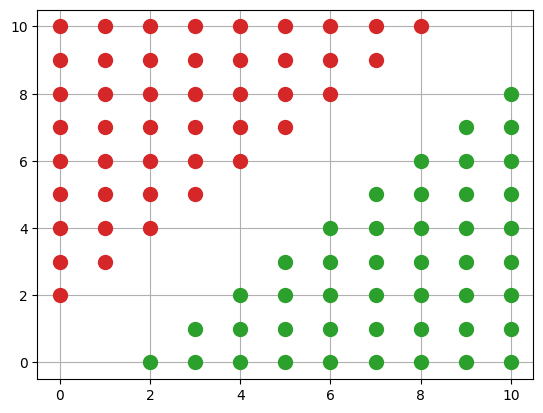

In [16]:
plot_uset(D)

visualizations can be useful to see the size of the domain or whether individual domains intersect.
In this example, domains are completely disjoint, which means they can be traversed by separate loop nests.

If the domain is parametric, you will have to first *fix* all parameter values to a constant by

* creating a parametric set where a domain value is fixed;
* intersecting your domain with this new set; and
* projecting out the parameters.

Here is how it can be done for `T` statement of our first example.

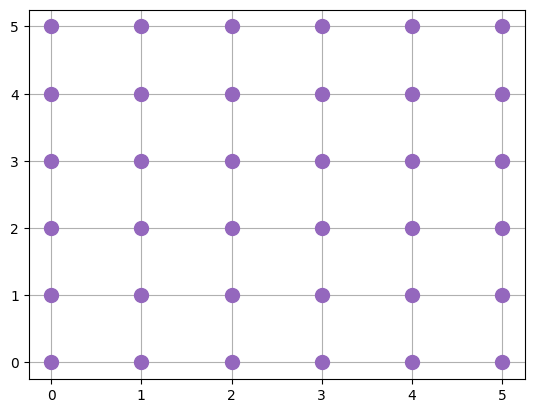

In [17]:
fixer = isl.Set("[N] -> {T[i,j]: N = 5}")
D_T = D_T.intersect(fixer)
D_T = D_T.project_out(isl.dim_type.param, 0, 1)
plot_uset(D_T)

The `isl.dim_type.param` means that you want to project out parameters, the two following numbers are the
position of the first parameter and the number of consecutive parameters that will be projected out.
For the sake of plotting, project out all of them. Note that if you forget to fix the parameter size, the set will become unbounded and cannot be plotted.

Similarly to parameters, you can project out domain dimensions until you get at most two before plotting.
Use `isl.dim_type.set` to get those.

### Question
In the following loop nest performing LU decomposition,

```c
for (i = 0; i < N; i++) {
  for (j = 0; j < i; j++) {
    for (k = 0; k < j; k++) {
Sa:    A[i][j] -= A[i][k] * A[k][j];
    }
Sb: A[i][j] /= A[j][j];
  }
  for (j = i; j < N; j++) {
    for (k = 0; k < i; k++) {
Sc:   A[i][j] -= A[i][k] * A[k][j];
    }
  }
}
```

1. Define the union set with all iteration domains.
1. Check if iteration domains of `Sa` and `Sc` overlap.
1. Plot projections on the domain on $(i,j)$, $(j,k)$.

Hint: it is impossible to project out domain dimensions *directly* from the union set
because it may have sets that live in different spaces.
However, a union set may be constructed from sets, and you can take a union of union sets.


In [18]:
#!Solution
D_Sa = isl.Set("[N] -> {Sa[i,j,k]: 0 <= i < N and 0 <= j < i and 0 <= k < j}") 
D_Sb = isl.Set("[N] -> {Sb[i,j]: 0 <= i < N and 0 <= j < i}")
D_Sc = isl.Set("[N] -> {Sc[i,j,k]: 0 <= i < N and i <= j < N and 0 <= k < i}")
D = isl.UnionSet(D_Sa).union(D_Sb).union(D_Sc)
display_latex(D)

<IPython.core.display.Math object>

In [19]:
#!Solution
D_Sa_notag = isl.Set("[N] -> {[i,j,k]: 0 <= i < N and 0 <= j < i and 0 <= k < j}") 
D_Sc_notag = isl.Set("[N] -> {[i,j,k]: 0 <= i < N and i <= j < N and 0 <= k < i}")
print(not D_Sa_notag.intersect(D_Sc_notag).is_empty())

False


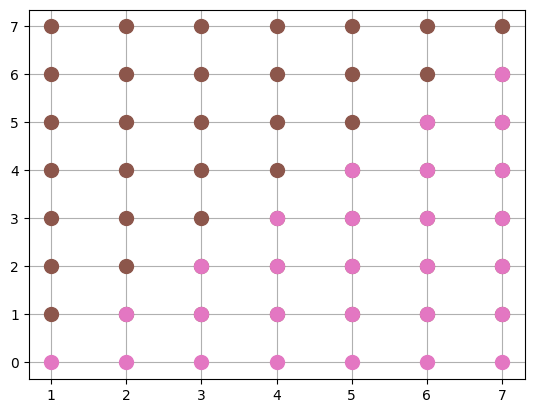

In [20]:
#!Solution
D_Sa = D_Sa.intersect(isl.Set("[N] -> {Sa[i,j,k]: N = 8}"))
D_Sb = D_Sb.intersect(isl.Set("[N] -> {Sb[i,j]: N = 8}"))
D_Sc = D_Sc.intersect(isl.Set("[N] -> {Sc[i,j,k]: N = 8}"))
D_Sa = D_Sa.project_out(isl.dim_type.param, 0, 1)
D_Sb = D_Sb.project_out(isl.dim_type.param, 0, 1)
D_Sc = D_Sc.project_out(isl.dim_type.param, 0, 1)
D_Sa = D_Sa.project_out(isl.dim_type.set, 2, 1)
D_Sc = D_Sc.project_out(isl.dim_type.set, 2, 1)
D = isl.UnionSet(D_Sa).union(D_Sb).union(D_Sc)
plot_uset(D)